In [ ]:
!pip install einops

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

from einops import rearrange
from sklearn.model_selection import train_test_split

## Import Data

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


## Observe Data

In [ ]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

X_train:  (60000, 28, 28)
X_test:  (10000, 28, 28)


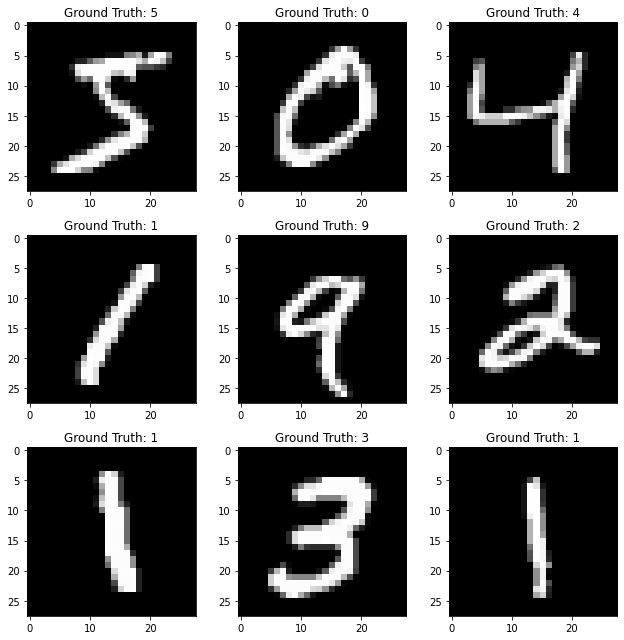

In [ ]:
fig = plt.figure(figsize=(9, 9))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(X_train[i], cmap="gray", interpolation="none")
    target = y_train[i]
    plt.title("Ground Truth: {}".format(int(target)))

plt.show()

## Preprocessing

In [ ]:
target_size = 10   # 0 ~ 9, 총 9개

### 주의: 흑백 데이터여도 channel 차원을 살려주어야 정상적으로 작동합니다
X_train = rearrange(X_train, "b h w -> b h w 1")
X_test = rearrange(X_test, "b h w -> b h w 1")

X_train = X_train.astype("float32") / (2 ** 8 - 1)   # 255로 scaling
X_test = X_test.astype("float32") / (2 ** 8 - 1)     # 255로 scaling

y_train = to_categorical(y_train, target_size)       # 타겟을 정수로 변환
y_test = to_categorical(y_test, target_size) 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

#ImageDataGenerator를 사용한 이미지 전처리(augmentation) 예제


자세한 설명은

https://keras.io/ko/preprocessing/image/

여기를 참고해 주세요!

** epoch당 ETA는 약 1시간입니다. 쓰려면 차라리 이걸 쓰세요.. 근데 그냥 쓰지 마세요... **

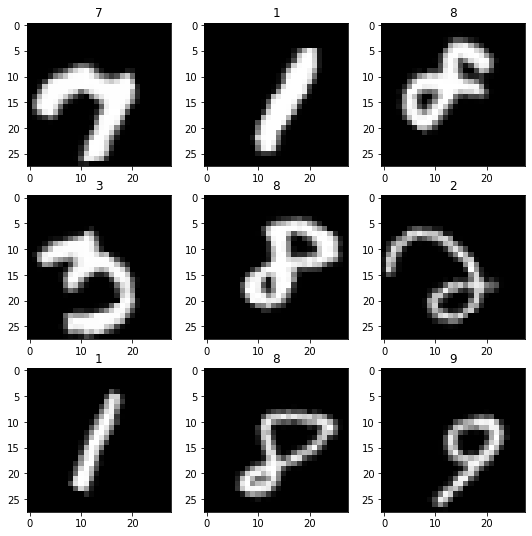

In [ ]:
# 전처리에 사용할 ImageDataGenerator 만들기
# 같은 방식으로 valid data도 전처리할 수 있습니다! 보통은 rotation만 사용하는 것
train_datagen = ImageDataGenerator(rotation_range=40,         # 무작위 회전 각도
                                   width_shift_range=0.1,     # 가로 shift 비율 (전체 너비 대비 비율)
                                   height_shift_range=0.1,    # 세로 shift 비율
                                   brightness_range=None,     # 밝기 변환 범위 ex) (0.2, 0.8)
                                   zoom_range=0.0,            # 확대 비율 (소수 1개 혹은 범위 지정 가능)
                                   horizontal_flip=False,     # 무작위 수평 전환
                                   vertical_flip=False,       # 무작위 수직 전환 (50% 확률)
                                   rescale=None)              # 크기 재조절 인수 (보통 1./255를 많이 사용하지만 같은 비율로 valid data도 처리해줘야함)
# val_datagen = ImageDataGenerator(recale=1./255)

train_flow = train_datagen.flow(X_train, y_train, batch_size=256, shuffle=True)
# val_flow = val_datagen.flow(X_val, y_val, batch_size=256, shuffle=False)

fig = plt.figure(figsize=(9, 9))
fig.tight_layout()

# ImageDataGenerator 결과 프린트
for X_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size=9, shuffle=True):
  for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.imshow(X_batch[i].reshape(28, 28), cmap="gray", interpolation="none")
    plt.title(np.argmax(y_batch[i]))
  plt.show()
  break


# Preprocessing layer를 사용한 이미지 전처리 예제

https://www.tensorflow.org/guide/keras/preprocessing_layers

https://ichi.pro/ko/imagedatageneratorboda-tensorflow-deiteoleul-seontaeghal-sigan-36689109001269

여기를 참고했습니다!

** 배경에 노이즈가 발생하는 경우가 있고 epoch당 ETA는 약 8시간입니다. **

웬만하면 쓰지 마세요....


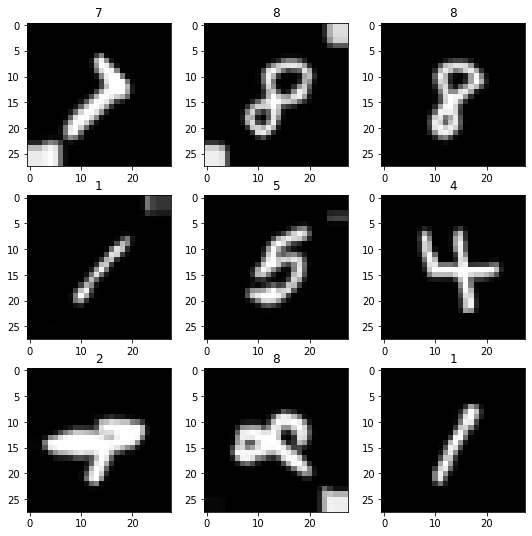

In [ ]:
# 데이터 전처리하기 (preprocessing layer를 사용한 모델)

data_augmentation = tf.keras.Sequential([
#  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='nearest')
#  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])

aug_image = data_augmentation(X_train)

###

fig = plt.figure(figsize=(9, 9))
fig.tight_layout()

# 예시 프린트
for i in range(9):
  plt.subplot(3, 3, 1 + i)
  plt.imshow(tf.reshape(aug_image[i],[28,28]), cmap="gray", interpolation="none")
  plt.title(np.argmax(y_train[i]))
plt.show()


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)
(48000, 10)
(12000, 10)
(10000, 10)


In [ ]:
inputs = Input(shape=(28, 28, 1))

X = Conv2D(filters=512, kernel_size=(5, 5), padding="Same")(inputs)
X = BatchNormalization()(X)
X = Activation("relu")(X)
X = Conv2D(filters=512, kernel_size=(5, 5), padding="Same", activation="relu")(X)
X = Dropout(0.5)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

X = Conv2D(filters=256, kernel_size=(5, 5), padding="Same")(X)
X = BatchNormalization()(X)
X = Activation("relu")(X)
X = Conv2D(filters=128, kernel_size=(5, 5), padding="Same", activation="relu")(X)
X = Dropout(0.5)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

X = Conv2D(filters=64, kernel_size=(3, 3), padding="Same")(X)
X = BatchNormalization()(X)
X = Activation("relu")(X)
X = Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu")(X)
X = Dropout(0.3)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

X = Flatten()(X)
X = Dense(1024, activation="relu")(X)
X = BatchNormalization()(X)
X = Dropout(0.2)(X)
X = Dense(256, activation="relu")(X)
X = BatchNormalization()(X)
X = Dropout(0.2)(X)
outputs = Dense(10, activation="softmax")(X)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 512)       13312     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 512)       2048      
_________________________________________________________________
activation (Activation)      (None, 28, 28, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 512)       6554112   
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 512)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 512)       0     

In [ ]:
model.compile(optimizer=RMSprop(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# ImageDataGenerator로 전처리한 train_flow를 사용해 학습합니다
# valid data도 전처리할 경우 validatioin_data=val_flow로 바꿔주세요
history = model.fit(train_flow, batch_size=256, epochs=15, validation_data=(X_val, y_val), verbose=1)

# (preprocessing layer) 전처리한 데이터를 사용해 학습합니다
history = model.fit(aug_image, y_train, batch_size=256, epochs=15, validation_data=(X_val, y_val), verbose=1)

Epoch 1/15
 12/188 [>.............................] - ETA: 8:06:43 - loss: 2.6734 - accuracy: 0.1914

## Sources
https://towardsdatascience.com/the-quest-of-higher-accuracy-for-cnn-models-42df5d731faf